<a href="https://colab.research.google.com/github/Gak02/voice_analysis_test/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa soundfile numpy pandas matplotlib

In [ ]:
# ---- 2) Upload audio ----
from google.colab import files
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]
print("Uploaded file:", audio_path)

Saving 2nd_try.m4a to 2nd_try.m4a
Uploaded file: 2nd_try.m4a


In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import math

In [ ]:
# ------------------------------
# Utils
# ------------------------------
def clamp(x, a, b):
    return max(a, min(b, x))

def mad(x):
    """Median Absolute Deviation (robust std proxy)"""
    x = np.asarray(x)
    if x.size == 0:
        return np.nan
    med = np.median(x)
    return np.median(np.abs(x - med))

def gauss_score(x, mu, sigma):
    """mu付近が100点、離れると滑らかに下がる"""
    return 100 * math.exp(-0.5 * ((x - mu) / sigma) ** 2)

def exp_decay_score(x, scale):
    """0が100点、増えるほど指数的に下がる"""
    return 100 * math.exp(-x / scale)

def log_squash01(x01, k=10):
    """
    0..1 を 0..1 のまま、外れ値（1付近）を圧縮して扱いやすくする
    """
    x01 = clamp(float(x01), 0.0, 1.0)
    return math.log1p(k * x01) / math.log1p(k)

In [ ]:
# ------------------------------
# Simple Denoise Preprocess
# ------------------------------
def highpass_filter_simple(y, sr, cutoff_hz=80, n_fft=2048, hop_length=512):
    """
    超簡易ハイパス：STFT上でcutoff未満の周波数をゼロにする
    依存なしで確実に動く（IIR/FIRより雑だがデモ用途には十分）
    """
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    D[freqs < cutoff_hz, :] = 0
    y_hp = librosa.istft(D, hop_length=hop_length, length=len(y))
    return y_hp

def spectral_gate_denoise(y, sr, n_fft=2048, hop_length=512, prop_decrease=1.0):
    """
    簡易スペクトルゲート
    - RMSの低いフレームを「ノイズ」とみなしてノイズプロファイル推定
    - (S - noise_floor) を下限0で抑制
    """
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S = np.abs(D)
    phase = np.exp(1j * np.angle(D))

    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
    thr = np.percentile(rms, 20)  # 低い20%を無音寄りとして扱う
    noise_frames = np.where(rms <= thr)[0]

    # 無音が少ないとノイズ推定が不安定 → そのまま返す
    if len(noise_frames) < 5:
        return y

    noise_profile = np.median(S[:, noise_frames], axis=1, keepdims=True)
    S_denoised = np.maximum(S - prop_decrease * noise_profile, 0.0)
    D_denoised = S_denoised * phase
    y_out = librosa.istft(D_denoised, hop_length=hop_length, length=len(y))
    return y_out

def preprocess_denoise(y, sr, hp_cutoff_hz=80, prop_decrease=1.0, n_fft=2048, hop_length=512):
    """
    1) ハイパス (低域ノイズ除去)
    2) スペクトルゲート (定常ノイズ抑制)
    """
    y1 = highpass_filter_simple(y, sr, cutoff_hz=hp_cutoff_hz, n_fft=n_fft, hop_length=hop_length)
    y2 = spectral_gate_denoise(y1, sr, n_fft=n_fft, hop_length=hop_length, prop_decrease=prop_decrease)
    y2 = librosa.util.normalize(y2)
    return y2

In [ ]:
# ------------------------------
# Robust Feature Extraction (denoised + voiced-only + MAD)
# ------------------------------
def analyze_voice_denoised(path,
                           hp_cutoff_hz=80,
                           prop_decrease=1.0,
                           frame_length=2048,
                           hop_length=512,
                           voiced_prob_th=0.8,
                           min_voiced_frames_for_jitter=10):
    """
    DENOISED-only analysis:
    - denoise preprocessing (highpass + spectral gating)
    - librosa.pyin for f0 + voiced flags
    - use voiced-only frames (and voiced_prob threshold)
    - jitter/shimmer: MAD based & log-scale for pitch stability
    """
    # load
    y, sr = librosa.load(path, sr=None, mono=True)
    y = librosa.util.normalize(y)

    # ✅ denoise
    y = preprocess_denoise(y, sr, hp_cutoff_hz=hp_cutoff_hz, prop_decrease=prop_decrease,
                           n_fft=frame_length, hop_length=hop_length)

    # RMS
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_mean = float(np.mean(rms))
    rms_std  = float(np.std(rms))
    rms_cv   = float(rms_std / (rms_mean + 1e-9))

    # silence ratio
    thr = np.percentile(rms, 25)
    silence_ratio  = float(np.mean(rms < thr))
    speech_density = 1.0 - silence_ratio

    # Pitch (pyin)
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y,
        fmin=70,
        fmax=400,
        sr=sr,
        frame_length=frame_length,
        hop_length=hop_length
    )

    mask = voiced_flag & np.isfinite(f0) & (voiced_prob >= voiced_prob_th)
    f0_v = f0[mask]

    f0_mean = float(np.mean(f0_v)) if len(f0_v) else np.nan
    f0_std  = float(np.std(f0_v))  if len(f0_v) else np.nan

    # Spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    centroid_mean = float(np.mean(centroid))

    # Robust jitter: MAD of diff(log2(f0)) on voiced-only
    if len(f0_v) >= min_voiced_frames_for_jitter:
        log_f0 = np.log2(f0_v)
        jitter_robust = float(mad(np.diff(log_f0)))
    else:
        jitter_robust = np.nan

    # Robust shimmer: MAD of diff(rms) normalized by median rms
    if len(rms) >= 10:
        shimmer_robust = float(mad(np.diff(rms)) / (np.median(rms) + 1e-9))
    else:
        shimmer_robust = np.nan

    voiced_ratio = float(np.mean(voiced_flag)) if len(voiced_flag) else np.nan

    features = {
        "duration_sec": float(len(y) / sr),
        "rms_mean": rms_mean,
        "rms_std": rms_std,
        "rms_cv": rms_cv,
        "silence_ratio": silence_ratio,
        "speech_density": float(speech_density),
        "f0_mean_hz": f0_mean,
        "f0_std_hz": f0_std,
        "spectral_centroid_mean": centroid_mean,
        "jitter_robust": jitter_robust,
        "shimmer_robust": shimmer_robust,
        "voiced_ratio": voiced_ratio,
        "hp_cutoff_hz": hp_cutoff_hz,
        "prop_decrease": prop_decrease,
        "voiced_prob_th": voiced_prob_th,
    }

    pack = (y, sr, rms, f0, voiced_flag, voiced_prob, centroid)
    return features, pack

In [ ]:
# ------------------------------
# Robust 0-100 Voice Health Score (denoised features)
# ------------------------------
def voice_health_score(f):
    """
    Outlier-resistant score:
    - jitter_robust and shimmer_robust are clipped + log-squashed
    - confidence adjusts jitter/shimmer impact using voiced_ratio
    NOTE: mu/sigma are demo defaults; for personal use, calibrate to your baseline.
    """
    # Pitch: "ほどよい抑揚"を高得点 (demo)
    pitch_score = gauss_score(f["f0_std_hz"], mu=18, sigma=18) if np.isfinite(f["f0_std_hz"]) else 50

    # Silence: 独り話デモの自然さ (demo)
    silence_score = gauss_score(f["silence_ratio"], mu=0.35, sigma=0.18)

    # Brightness: ほどよい明るさ (demo)
    centroid_score = gauss_score(f["spectral_centroid_mean"], mu=2200, sigma=800)

    # Loudness stability
    rms_cv = f.get("rms_cv", f["rms_std"]/(f["rms_mean"]+1e-9))
    rms_stability_score = exp_decay_score(clamp(rms_cv, 0, 3), scale=0.6)

    # Robust jitter: expected-ish range 0..0.06 (demo)
    j = f.get("jitter_robust", np.nan)
    if np.isfinite(j):
        j_clip = clamp(j, 0, 0.06)
        j01 = j_clip / 0.06
        j_sq = log_squash01(j01, k=12)
        jitter_score = 100 * (1 - j_sq)
    else:
        jitter_score = 50

    # Robust shimmer: expected-ish range 0..0.6 (demo)
    s = f.get("shimmer_robust", np.nan)
    if np.isfinite(s):
        s_clip = clamp(s, 0, 0.6)
        s01 = s_clip / 0.6
        s_sq = log_squash01(s01, k=8)
        shimmer_score = 100 * (1 - s_sq)
    else:
        shimmer_score = 50

    # Duration reliability
    duration_score = 100 if f["duration_sec"] >= 20 else 100 * (f["duration_sec"] / 20)

    # Confidence: voiced_ratio low => reduce jitter/shimmer influence
    vr = f.get("voiced_ratio", 1.0)
    conf = clamp(vr if np.isfinite(vr) else 1.0, 0.3, 1.0)
    jitter_score  = 50 + (jitter_score  - 50) * conf
    shimmer_score = 50 + (shimmer_score - 50) * conf

    subs = {
        "pitch_score": pitch_score,
        "jitter_score": jitter_score,
        "shimmer_score": shimmer_score,
        "rms_stability_score": rms_stability_score,
        "silence_score": silence_score,
        "centroid_score": centroid_score,
        "duration_score": duration_score,
        "voiced_ratio": vr,
        "rms_cv": rms_cv,
        "jitter_robust": j,
        "shimmer_robust": s,
    }

    weights = {
        "pitch_score": 20,
        "jitter_score": 18,
        "shimmer_score": 10,
        "rms_stability_score": 12,
        "silence_score": 20,
        "centroid_score": 10,
        "duration_score": 10,
    }

    total = sum(subs[k] * weights[k] for k in weights) / sum(weights.values())
    return float(total), subs

In [ ]:
# ------------------------------
# Plot
# ------------------------------
def plot_summary(y, sr, rms, f0, voiced_flag, centroid, hop_length=512):
    t = np.arange(len(y)) / sr
    t_rms = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
    t_f0  = librosa.frames_to_time(np.arange(len(f0)),  sr=sr, hop_length=hop_length)
    t_cen = librosa.frames_to_time(np.arange(len(centroid)), sr=sr, hop_length=hop_length)

    plt.figure(figsize=(12, 3))
    plt.plot(t, y)
    plt.title("Waveform (denoised)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t_rms, rms)
    plt.title("RMS (loudness proxy)")
    plt.xlabel("Time (s)")
    plt.ylabel("RMS")
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t_f0, f0, linewidth=1)
    if voiced_flag is not None and len(voiced_flag) == len(f0):
        voiced_idx = np.where(voiced_flag)[0]
        plt.scatter(t_f0[voiced_idx], f0[voiced_idx], s=5)
    plt.title("F0 (pitch) via pyin (scatter=voiced)")
    plt.xlabel("Time (s)")
    plt.ylabel("Hz")
    plt.ylim(50, 450)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t_cen, centroid)
    plt.title("Spectral centroid (brightness proxy)")
    plt.xlabel("Time (s)")
    plt.ylabel("Hz")
    plt.show()

/tmp/ipython-input-2691844578.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


=== Voice Health Score (0-100) [DENOISED] ===
Score: 73.2

=== Features [DENOISED] ===


,value
duration_sec,36.884000
rms_mean,0.064082
rms_std,0.067582
rms_cv,1.054617
silence_ratio,0.250145
speech_density,0.749855
f0_mean_hz,139.963248
f0_std_hz,17.336233
spectral_centroid_mean,1971.016878
jitter_robust,NaN



=== Subscores [DENOISED] ===


,value
pitch_score,99.932031
jitter_score,50.000000
shimmer_score,54.027510
rms_stability_score,17.244179
silence_score,85.737915
centroid_score,95.986417
duration_score,100.000000
voiced_ratio,0.401677
rms_cv,1.054617
jitter_robust,NaN


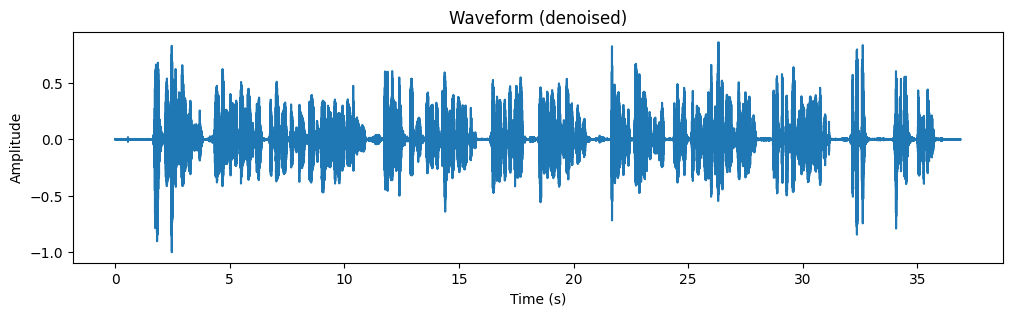

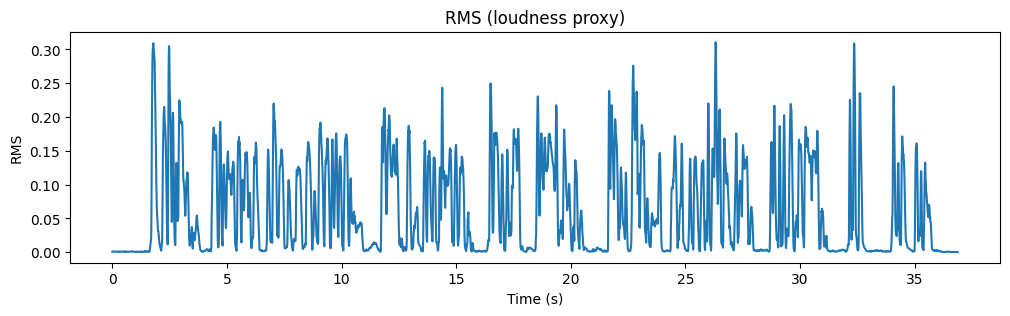

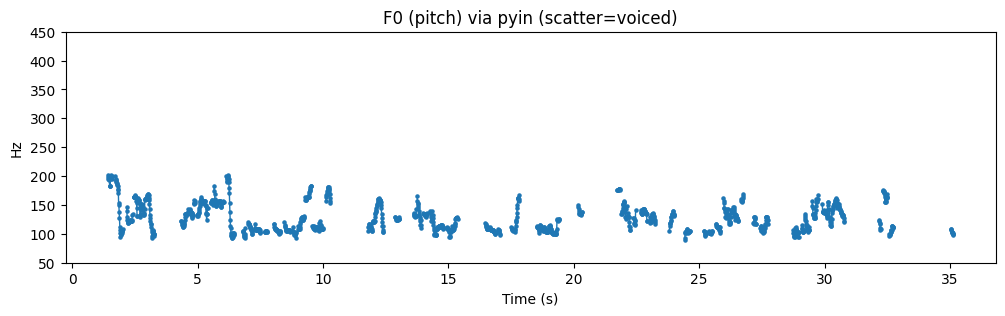

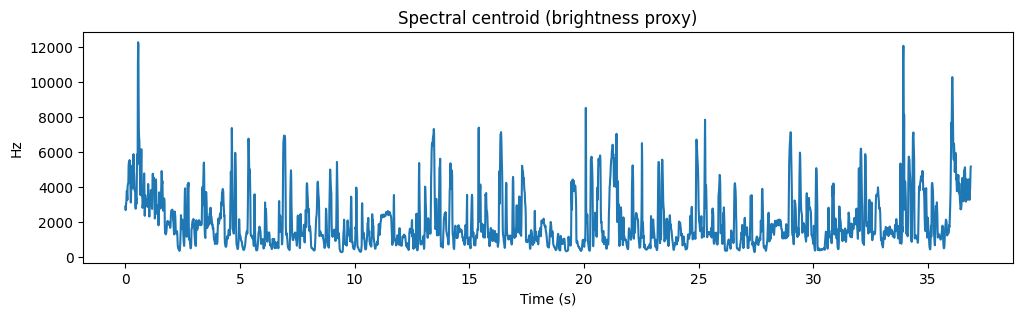

In [ ]:
# ------------------------------
# Run (DENOISED only)
# ------------------------------
# Tune if needed:
HP_CUTOFF_HZ = 80        # 80〜100 recommended for low male voice; 100〜120 for higher/noisy
PROP_DECREASE = 1.0      # 0.8 (mild)〜1.2 (strong). If voice sounds "thin", reduce.
VOICED_PROB_TH = 0.8     # 0.7〜0.9. Higher => more strict voiced frames.

features, pack = analyze_voice_denoised(
    audio_path,
    hp_cutoff_hz=HP_CUTOFF_HZ,
    prop_decrease=PROP_DECREASE,
    voiced_prob_th=VOICED_PROB_TH
)

score, subs = voice_health_score(features)

print("=== Voice Health Score (0-100) [DENOISED] ===")
print("Score:", round(score, 1))

print("\n=== Features [DENOISED] ===")
display(pd.DataFrame(features, index=["value"]).T)

print("\n=== Subscores [DENOISED] ===")
display(pd.DataFrame(subs, index=["value"]).T)

y, sr, rms, f0, voiced_flag, voiced_prob, centroid = pack
plot_summary(y, sr, rms, f0, voiced_flag, centroid, hop_length=512)